#### 1 WT4, DJF (Wet California)
 - 1.1) Find the top 25% of years that have the highest frequency of WT4 in DJF
 - 1.2) Calculate the seasonal mean 850 for those top 25% of years.
 - 1.3) Calculate the seasonal mean/STD over all years. 
 - 1.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty) 
 
#### 2 WT9 JAS (Wet Monson) 
 - 2.1) Find the top 25% of years that have the highest frequency of WT9 in ASO
 - 2.2) Calculate the seasonal mean 850 for those top 25% of years.
 - 2.3) Calculate the seasonal mean/STD over all years. 
 - 2.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty) 
 
#### 3 WT Seasonal Climatology

In [15]:
import os
import os.path
import glob 
import math
from matplotlib import pyplot
from matplotlib.cm import get_cmap
 
from netCDF4 import Dataset,num2date,date2num
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
#
import metpy.calc as mpcalc
import xarray as xr
import cartopy.crs as ccrs
import matplotlib
import cartopy.feature as cfe
import numpy as np
import matplotlib.pyplot as plt
import datetime
 
import metpy.calc as mpcalc

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
import sys
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)
from coexist_func import plot_single
from coexist_func import find_year_top25_wt_smyle
from coexist_func import cal_seasonalmean_wt_smyle
from coexist_func import cal_season_std_smyle
from coexist_func import cal_season_cli_qspd850_smyle 
from coexist_func import cal_season_ano_qspd850_smyle
from coexist_func import ax_coastlines_country
from coexist_func import plot_prec_12

#### calculate 850 hPa qspd from Q, U,V 

In [16]:

year_s = 1979
year_e = 2019
n_year = year_e - year_s + 1

ini_s = ['02', '05', '08', '11']
n_ini = len(ini_s)

dir_o    = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/'
dir_smyle = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'

n_mem = 20
 
for mem in range(1, n_mem+1, 1):
    #print('member', mem)
    mem_s = str(mem).zfill(3)
    mem_s2 = str(mem).zfill(2)
    for year in range(year_s, year_e+1, 1):
        for ni_s in ini_s:
            flnm_o = dir_o + 'qspd850_' +  str(year) + '-' + ni_s + '.' + mem_s2 + '.nc'
            #print(year, year_s,year_e)
            if os.path.isfile(flnm_o):
                if mem == 1 and year == year_s:
                    print(flnm_o, 'exist')
            else:
                # read SMYLE file
                dir_i = dir_smyle + 'b.e21.BSMYLE.f09_g17.' + str(year) +  \
                    '-' + ni_s + '.' + mem_s + '/atm/proc/tseries/day_1/'   
                flnm_q = glob.glob(dir_i + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' + mem_s + '.cam.h1.Q850.*nc')
                flnm_u = glob.glob(dir_i + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' + mem_s + '.cam.h1.U850.*nc')
                flnm_v = glob.glob(dir_i + 'b.e21.BSMYLE.f09_g17.' + str(year) + '-' + ni_s + '.' + mem_s + '.cam.h1.V850.*nc')
            
                with xr.open_dataset(flnm_q[0]) as ds_q:
                    q = ds_q['Q850']
                 
                with xr.open_dataset(flnm_u[0]) as ds_u:
                    u = ds_u['U850']
                with xr.open_dataset(flnm_v[0]) as ds_v:
                    v = ds_v['V850']
                
                qspd = (q*(u*u + v*v)**(1/2)).rename('qspd850')
                
                print(flnm_o)
                qspd.to_netcdf(flnm_o)  
                

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_1979-02.01.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_1979-05.01.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_1979-08.01.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_1979-11.01.nc exist


In [17]:
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/'

season_dict = {
    'DJF': [12,1,2],
    'MAM': [3,4,5],
    'JJA': [6,7,8],
    'SON': [9,10,11],
    'JAS': [7,8,9]}

n_season = len(season_dict)

n_wt = 12

lat_s = -20
lat_e = 80
lon_s = 0
lon_e = 360

n_fcst = 731

flnm = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_1979-02.01.nc'
with  xr.open_dataset(flnm) as ds:
    #print(ds)
    qspd850 = ds.qspd850.sel(lat=slice(lat_s, lat_e),lon=slice(lon_s, lon_e))
    latitude = ds['lat'].sel(lat=slice(lat_s, lat_e)) 
    longitude = ds['lon'] 
    n_lat = len(latitude)
    n_lon = len(longitude)
    print(qspd850)

<xarray.DataArray 'qspd850' (time: 731, lat: 106, lon: 288)>
[22315968 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 77.75 78.69 79.63
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1979-02-01 00:00:00 ... 1981-02-01 00:00:00


In [18]:
# for winter DJF season_dict[1]
key = 'DJF'

# target WT 4
wt_t = 4

year_p75 = find_year_top25_wt_smyle(year_s, year_e, season_dict, dir_wt, wt_t, key) 

member 1 -  20
        z500
1979    63.0
1980  1193.0
2006  2093.0
1998  2195.0
2007  2205.0
1982  2214.0
1986  2252.0
1992  2269.0
1988  2271.0
1990  2271.0
2013  2289.0
1995  2304.0
2010  2315.0
2003  2325.0
1983  2326.0
2002  2332.0
1994  2343.0
2015  2364.0
2008  2368.0
1981  2374.0
2012  2378.0
1991  2382.0
2017  2400.0
1996  2406.0
1987  2407.0
2019  2408.0
1984  2417.0
2011  2418.0
2014  2422.0
1999  2443.0
1985  2451.0
2005  2455.0
2016  2456.0
2001  2500.0
2018  2500.0
1997  2526.0
2009  2529.0
2004  2529.0
1993  2571.0
1989  2583.0
2000  2651.0
top 25% years are Int64Index([2005, 2016, 2001, 2018, 1997, 2009, 2004, 1993, 1989, 2000], dtype='int64')


- 1.2) Calculate the seasonal mean qdiv850 for those top 25% of years

In [19]:
flnm_o = dir_o + 'qspd850_p75_wt' + str(wt_t) + '_'+ key +'.nc'
qspd850_p75_2d_xr = cal_seasonalmean_wt_smyle('qspd850', dir_o, season_dict, key, year_p75, lat_s, lat_e,lon_s, lon_e, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_p75_wt4_DJF.nc exist
mean of member 1-20 
Frozen({'lat': 106, 'lon': 288})


- 1.3) read the seasonal mean and STD over all years

In [20]:
flnm_o = dir_o + 'qspd850_'+ key +'_MeanStd.nc'
var_cli_xr = cal_season_std_smyle('qspd850', dir_o, season_dict, key, year_s, year_e, latitude, longitude, lat_s, lat_e, flnm_o)
var_xr = var_cli_xr[0]
var_std_xr= var_cli_xr[1]

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_DJF_MeanStd.nc exist
Frozen({'mean_std': 2, 'lat': 106, 'lon': 288})


- 1.4) Plot the anomaly of the top 25% of years (P75-climatoloty)/stddev(climatoloty)

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


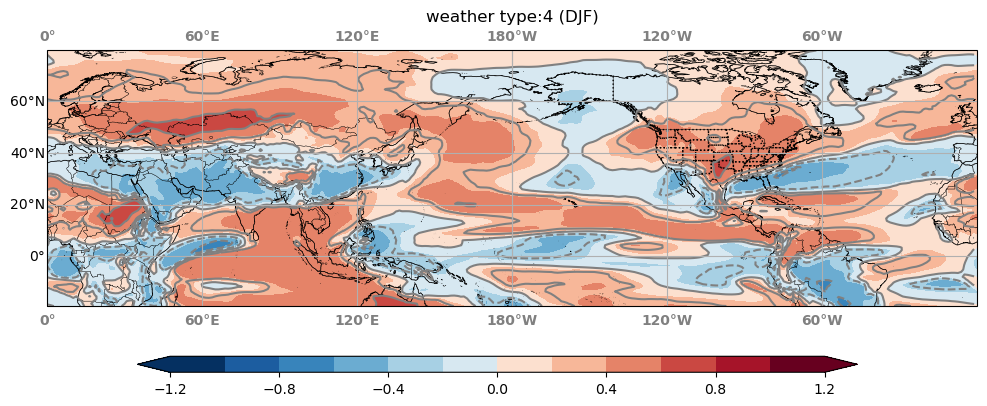

In [9]:
ano_2d = (qspd850_p75_2d_xr - var_xr)/var_std_xr
plot_single(ano_2d, wt_t, key, -1.2, 1.2, 13)

#### 2) WT9 (wet monsoon) for JAS
- 2.1) Find the top 25% of years that have the highest frequency of WT9 in JAS

In [10]:
# for winter DJF season_dict[1]
key = 'JAS'

# target WT 9
wt_t = 9

year_p75 = find_year_top25_wt_smyle(year_s, year_e, season_dict, dir_wt, wt_t, key) 

member 1 -  20
        z500
1979  1782.0
1980  4427.0
2011  4869.0
2010  4882.0
2007  4956.0
2008  5094.0
1999  5123.0
2013  5228.0
2012  5279.0
1983  5280.0
2016  5287.0
1998  5339.0
1988  5347.0
1996  5356.0
2006  5399.0
2000  5402.0
2015  5479.0
1995  5482.0
2017  5494.0
2014  5498.0
1994  5500.0
2004  5507.0
2005  5549.0
1985  5564.0
1989  5579.0
2019  5592.0
1987  5600.0
1991  5610.0
1981  5620.0
1984  5624.0
2018  5627.0
1990  5629.0
1986  5656.0
2003  5668.0
1997  5722.0
2002  5733.0
2001  5756.0
2009  5760.0
1993  5767.0
1992  5813.0
1982  5876.0
top 25% years are Int64Index([1990, 1986, 2003, 1997, 2002, 2001, 2009, 1993, 1992, 1982], dtype='int64')


- 2.2) Calculate the seasonal mean Z50 for those top 25% of years.

In [11]:
flnm_o = dir_o + 'qspd850_p75_wt' + str(wt_t) + '_'+ key +'.nc'
qspd850_p75_2d_xr = cal_seasonalmean_wt_smyle('qspd850',dir_o, season_dict, key, year_p75, lat_s, lat_e,lon_s, lon_e, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_p75_wt9_JAS.nc exist
mean of member 1-20 
Frozen({'lat': 106, 'lon': 288})


- 2.3) read the seasonal mean and STD over all years

In [12]:
flnm_o = dir_o + 'qspd850_'+ key +'_MeanStd.nc'
var_cli_xr = cal_season_std_smyle('qspd850', dir_o, season_dict, key, year_s, year_e, latitude, longitude, lat_s, lat_e, flnm_o)
var_xr = var_cli_xr[0]
var_std_xr= var_cli_xr[1]

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_JAS_MeanStd.nc exist
Frozen({'mean_std': 2, 'lat': 106, 'lon': 288})


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'vcenter'
  result = super().contourf(*args, **kwargs)


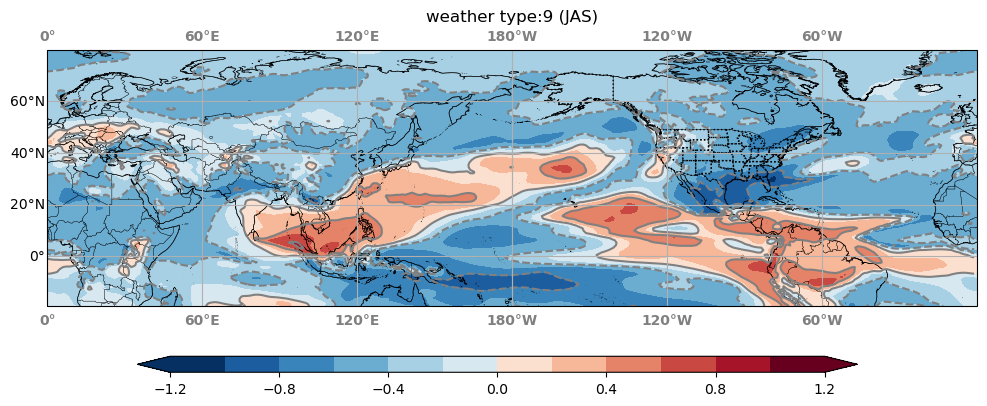

In [14]:
ano_2d = (qspd850_p75_2d_xr - var_xr)/var_std_xr
plot_single(ano_2d, wt_t, key, -1.2, 1.2, 13)

#### seasonal climatology
- 3.1) seasonal climatology

In [9]:
flnm_o = dir_o + 'qspd850_seasonal_cli.nc'
z500_cli_xr = cal_season_cli_qspd850_smyle('qspd850', dir_o, season_dict, year_s, year_e, latitude, longitude, lat_s, lat_e, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/qdiv850/qspd850_seasonal_cli.nc exist
Frozen({'lat': 106, 'lon': 288, 'season': 4})


- 3.2) seasonal anmoamly

In [24]:
flnm_cli = dir_o + 'qspd850_seasonal_cli.nc'
#flnm_o = dir_o + 'qspd850_seasonal_ano.nc'
z500_wt = cal_season_ano_qspd850_smyle('qspd850', dir_o, dir_wt, season_dict, year_s, year_e, latitude, longitude, lat_s, lat_e, flnm_cli)

/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem001.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem001.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem002.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem002.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem003.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem003.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem004.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem004.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem005.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem005.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/WT_init/qspd850_seasonal_ano_mem006.nc exist
/glade/campaign/mmm/c3we/ming

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


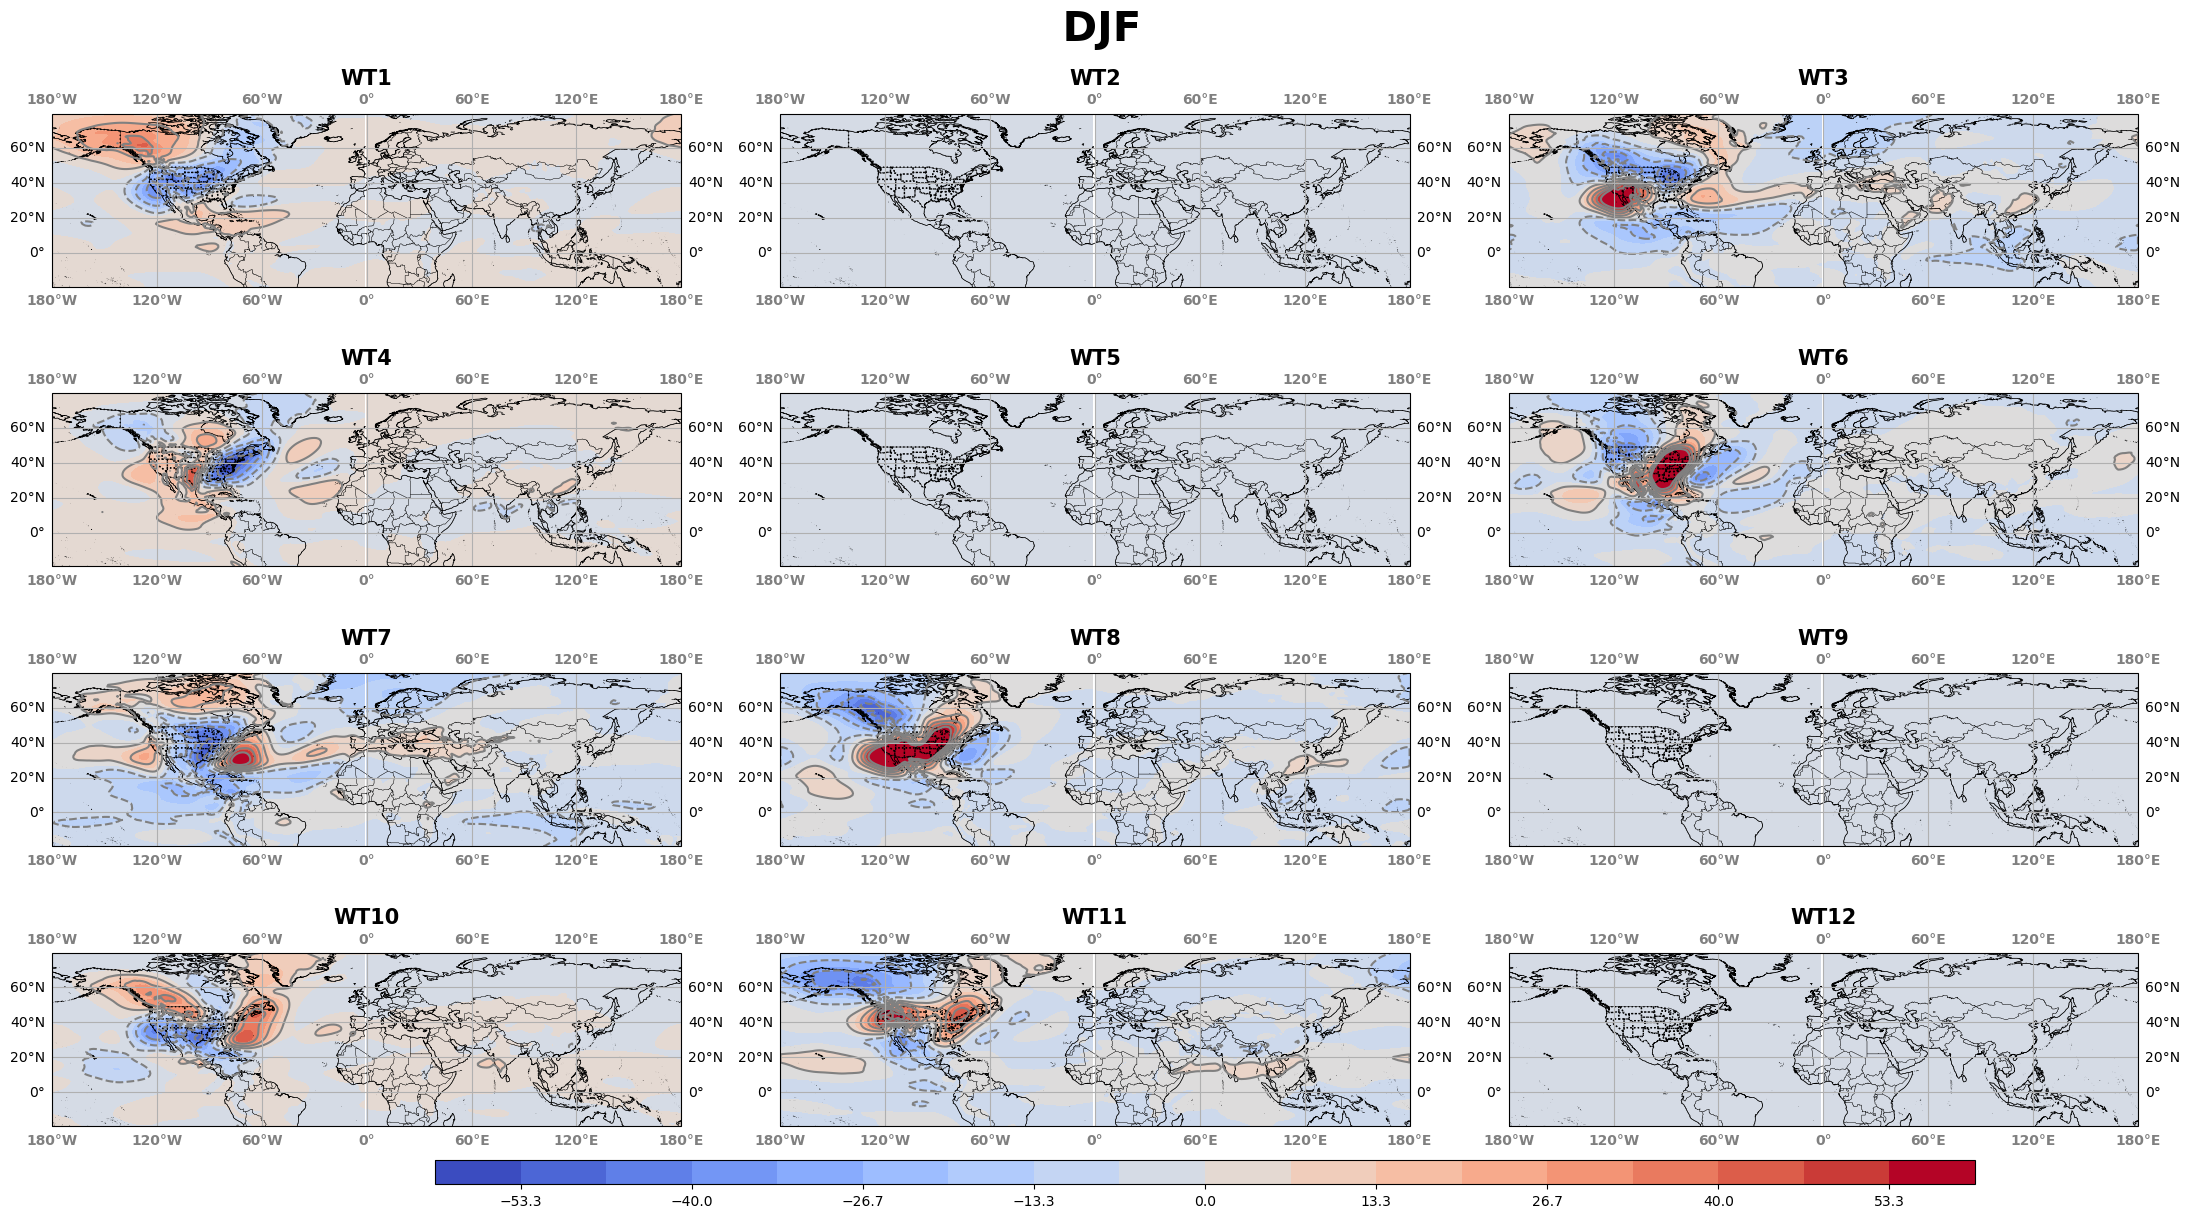

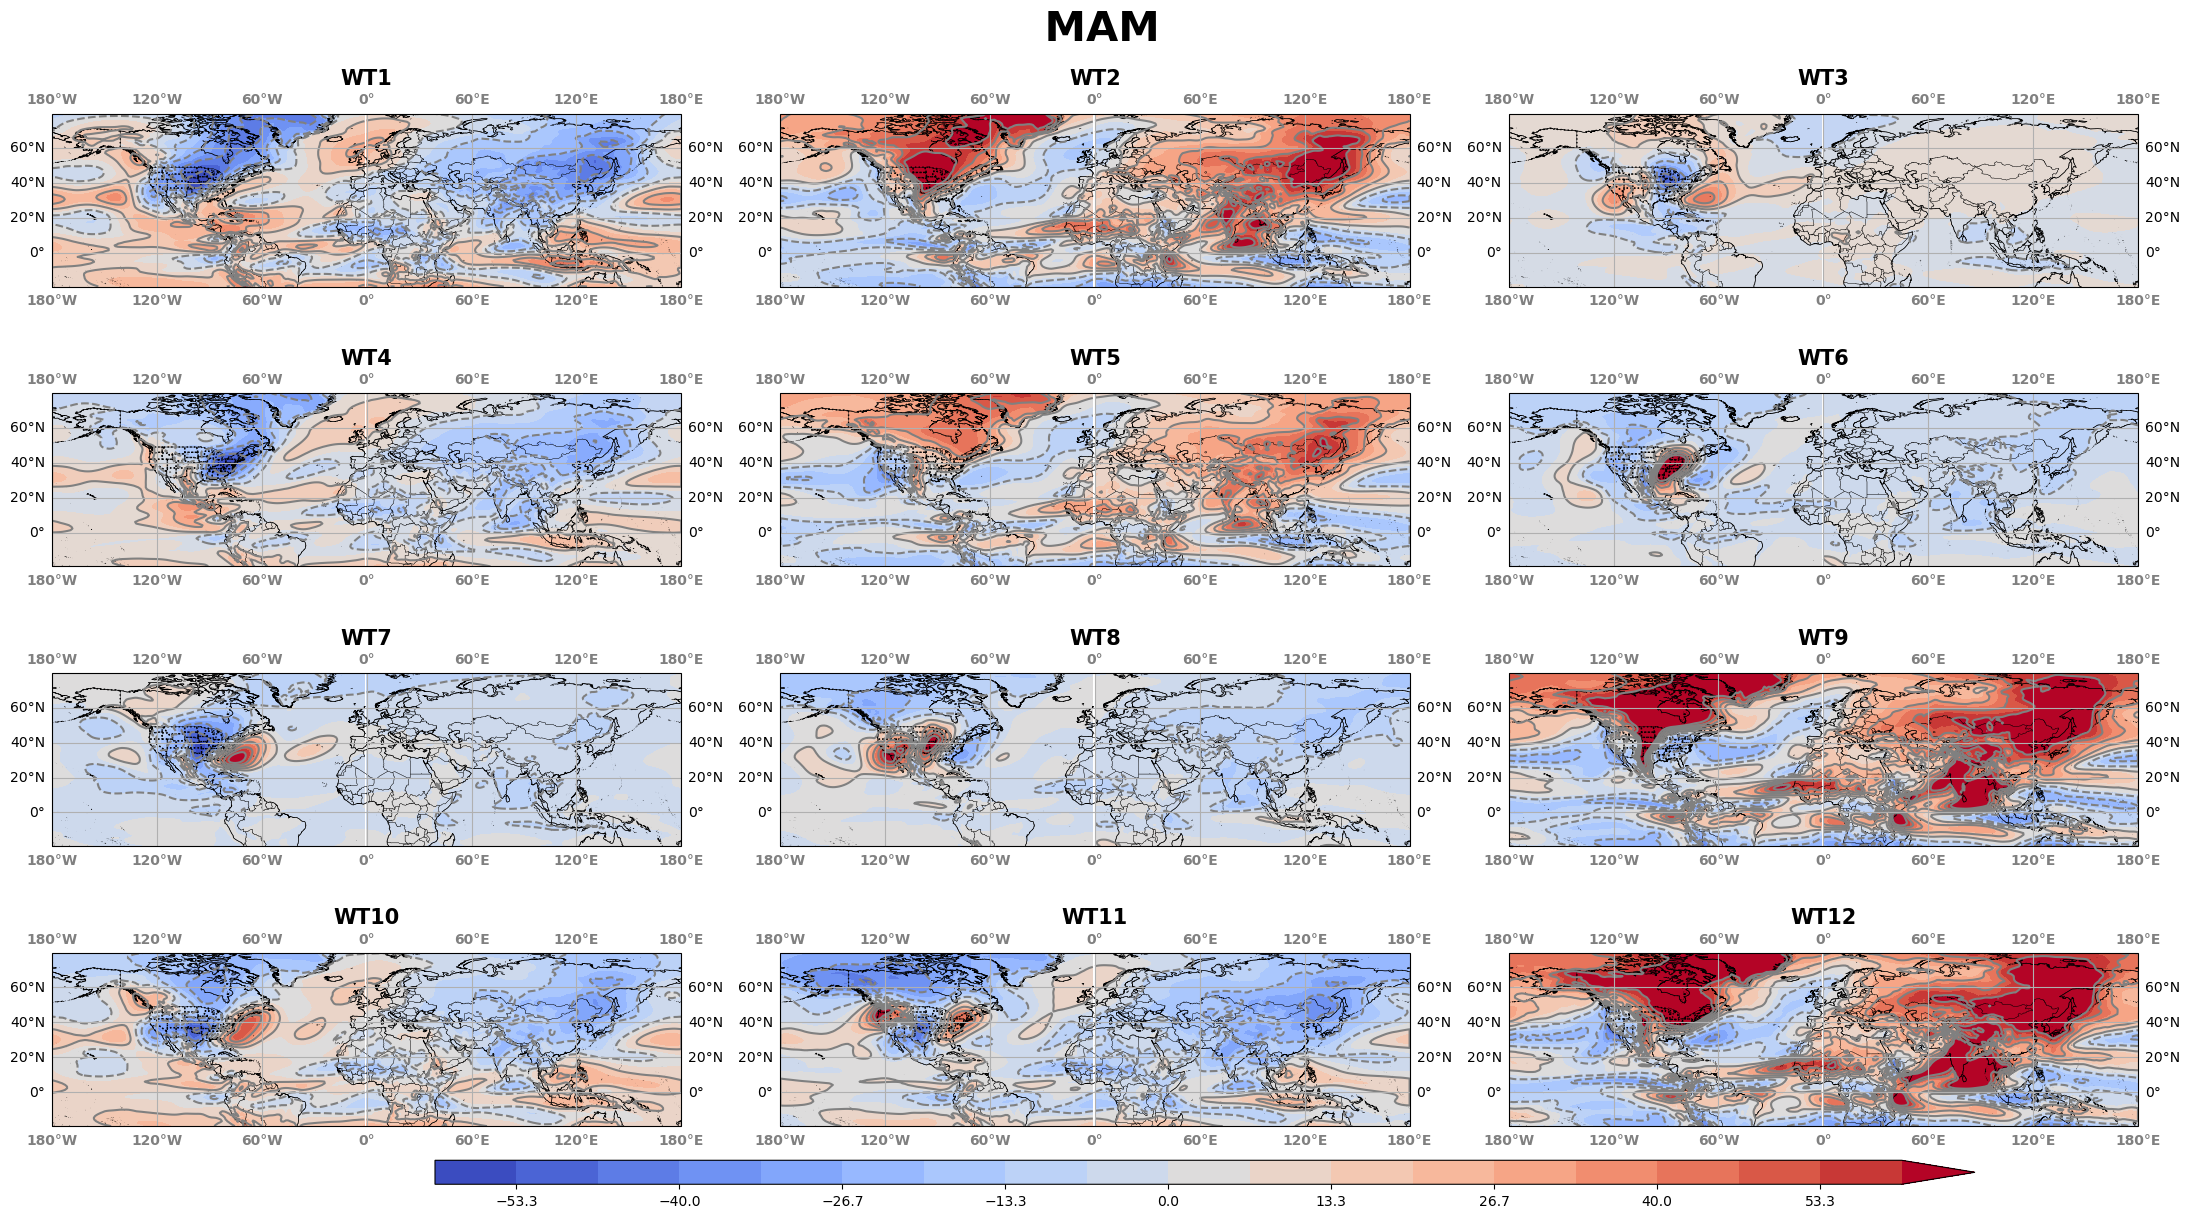

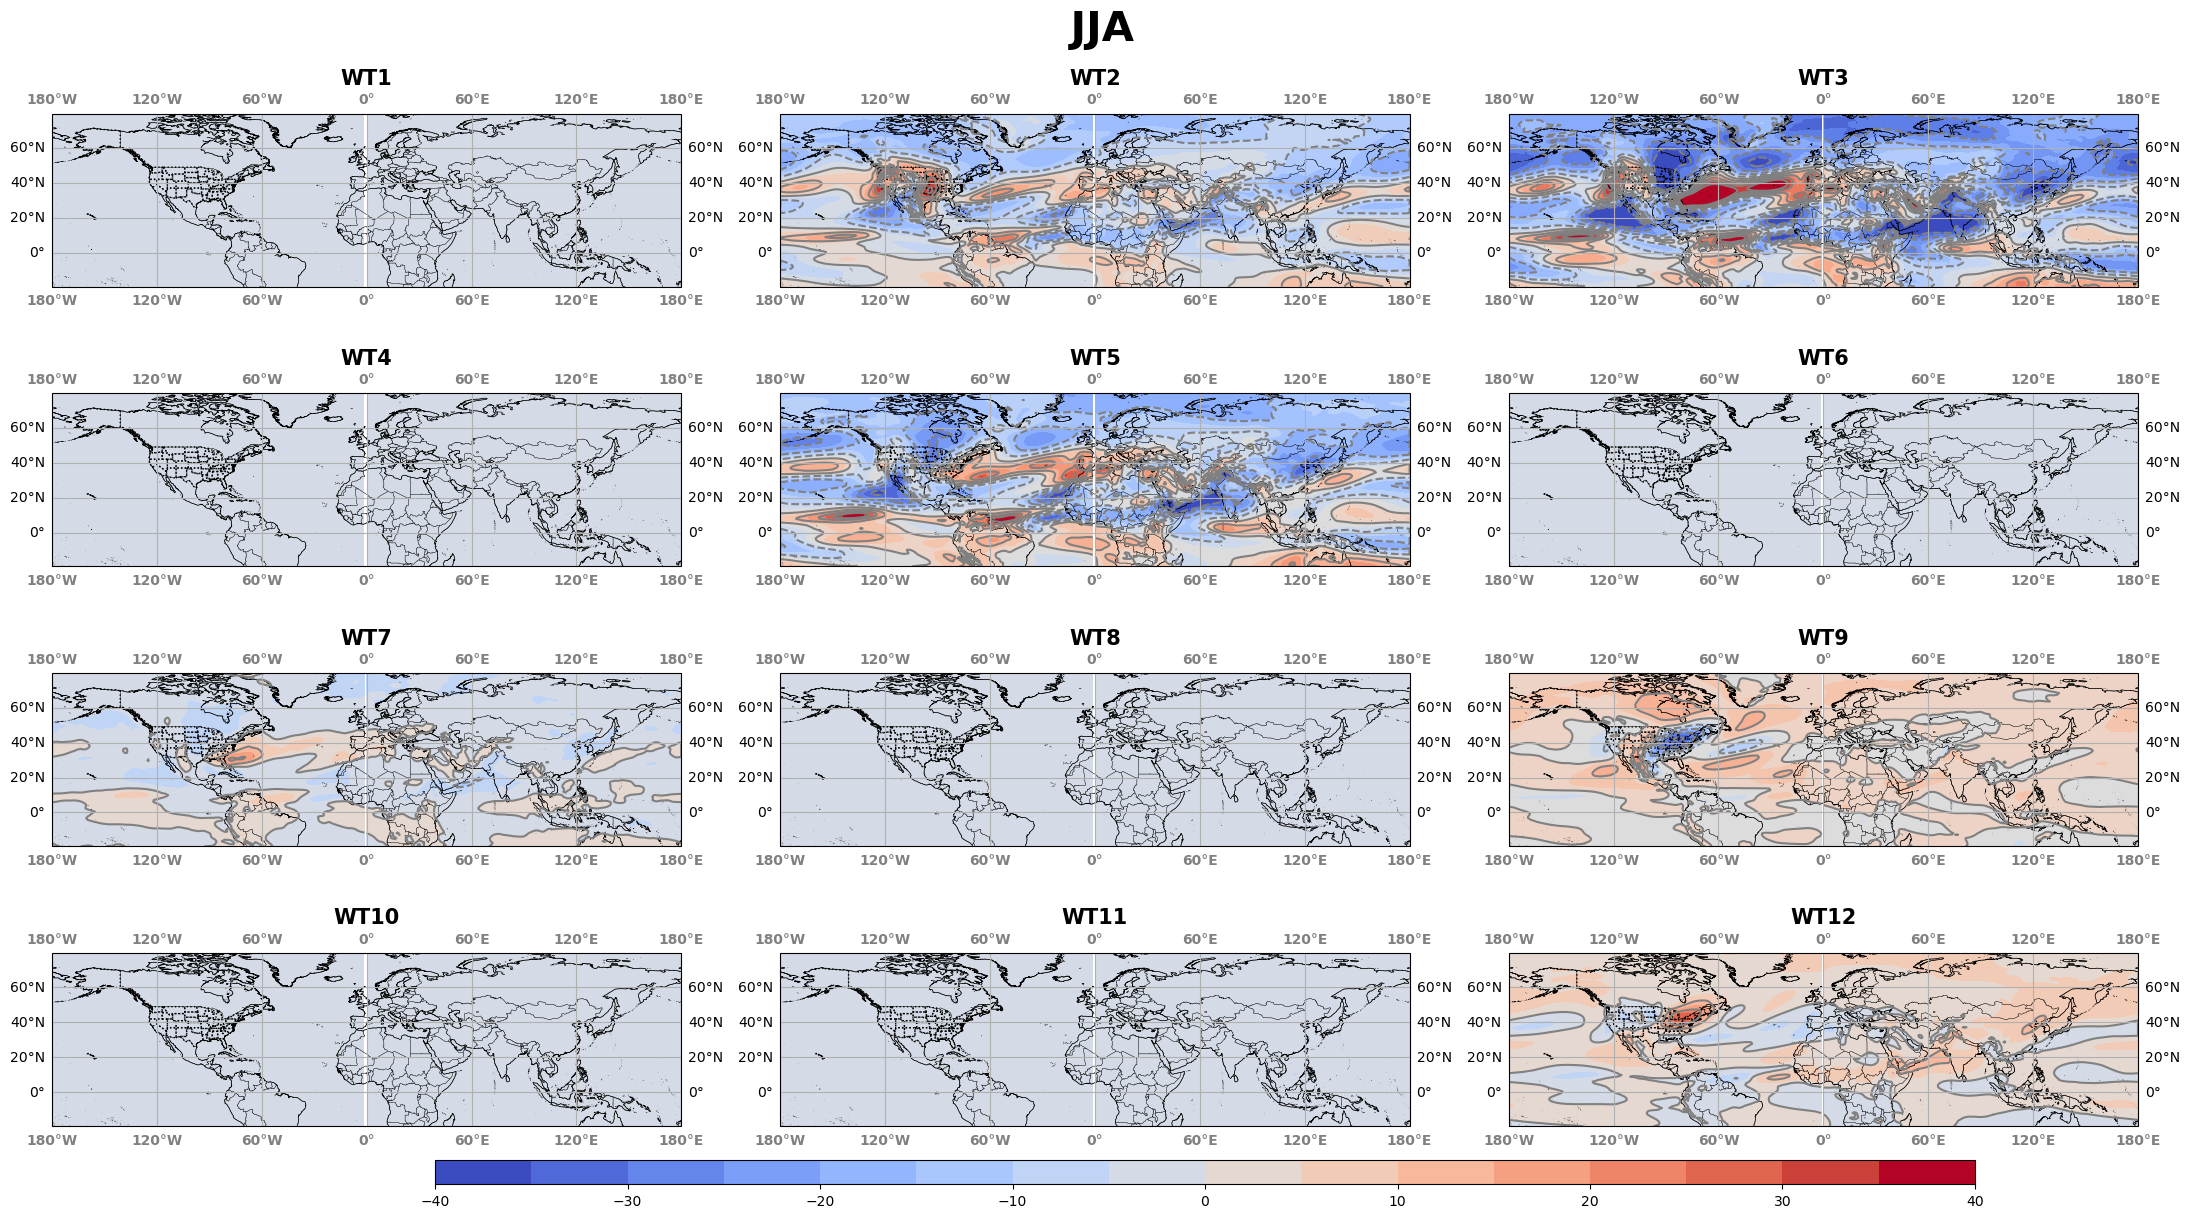

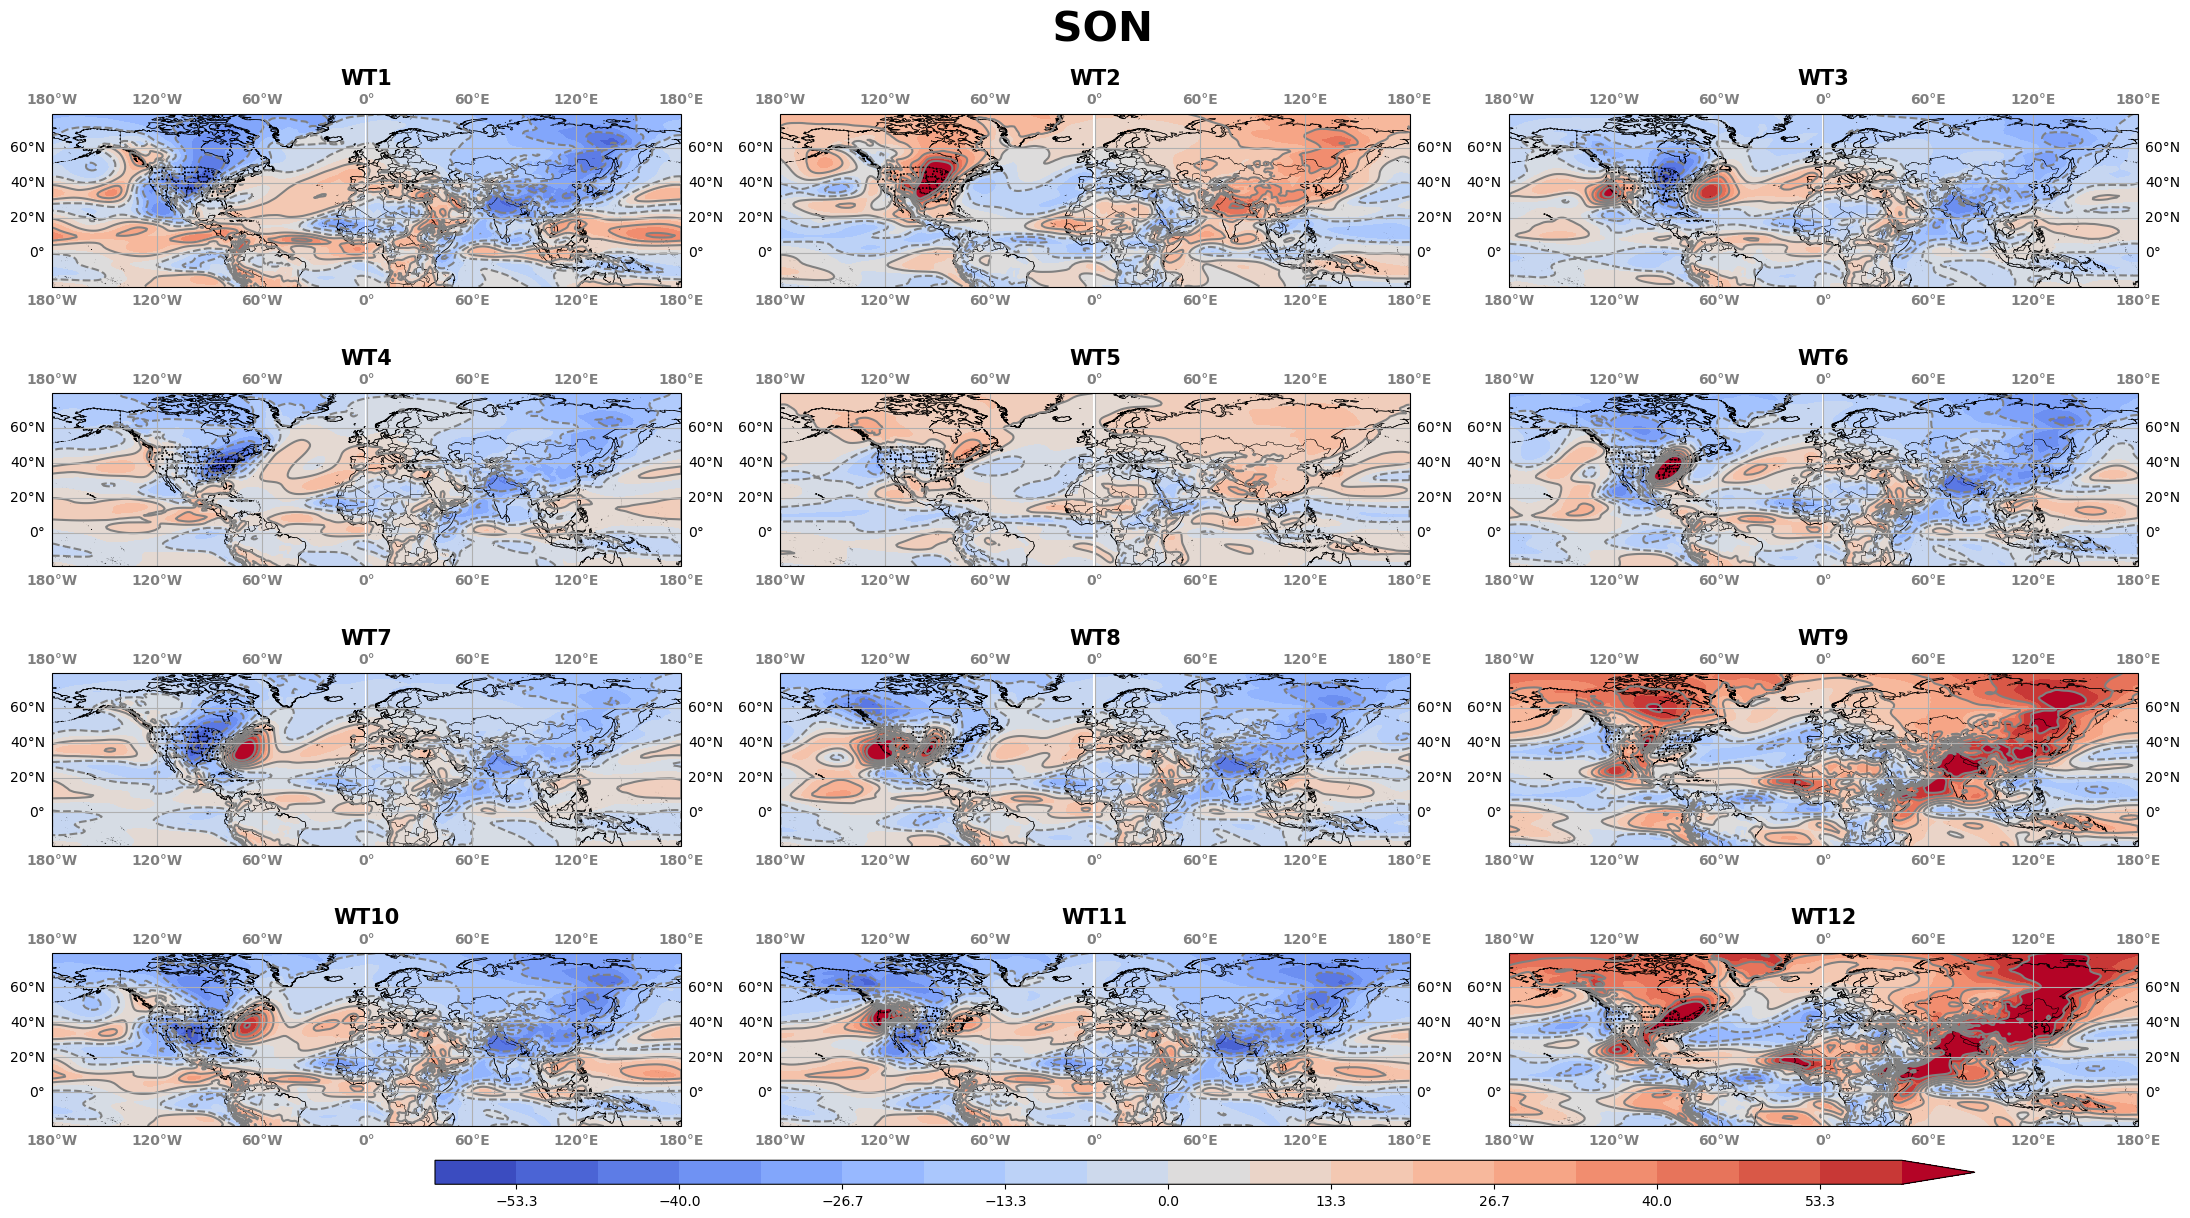

In [23]:
for mem in range(1,21):
    mem_s = str(mem).zfill(3) 
    flnm = dir_wt + 'qspd850_seasonal_ano_mem' + mem_s + '.nc'
    mem_s = str(mem).zfill(2) 
    with  xr.open_dataset(flnm) as ds:
        # proj = ccrs.PlateCarree(central_longitude=180)
        # longitude from [-180, 180] -> [0,360]
        #ds.coords['longitude'] = xr.where(ds['longitude'] < 0, ds['longitude'] + 360, ds['longitude'])
        #ds = ds.sortby(ds.longitude)
        if mem == 1: 
            z500_wt = ds.__xarray_dataarray_variable__
        else:
            z500_wt = z500_wt + ds.__xarray_dataarray_variable__

season_s = ['DJF','MAM','JJA','SON']            
 
# Because proj = ccrs.PlateCarree(central_longitude=180)
# I need to convert longitude from [-180, 180] -> [0,360]
z500_wt.coords['lon'] = xr.where(z500_wt['lon'] < 0, z500_wt['lon'] + 360, z500_wt['lon'])
z500_wt = z500_wt.sortby(z500_wt.lon)
 
z500_wt = z500_wt/20*100
 
for ns in range(4):  
    if ns == 2:     
        plot_prec_12(z500_wt[:,ns], -40, 40, 17, 'coolwarm', 'horizontal', season_s[ns]);
    else:
        plot_prec_12(z500_wt[:,ns], -60, 60, 19, 'coolwarm', 'horizontal', season_s[ns]); 
      